In [1]:
import numpy as np
import sys
sys.path.append('/home/marcobonici/Desktop/CosmologicalEmulators/PyEffort/src') # write the path were you put PyEffort
import PyEffort
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
emu_xi = PyEffort.load_emu("/home/marcobonici/Desktop/CosmologicalEmulators/trained_emulators/test_train_velocileptor_xi/trained_velocileptor_xi_l_0_z1.bson")
input_cosmo = np.array([3.037842, 0.9553725, 0.67123, 0.0230248, 0.142591])
Xil_test = PyEffort.compute_Xil(input_cosmo, np.ones(6), emu_xi)

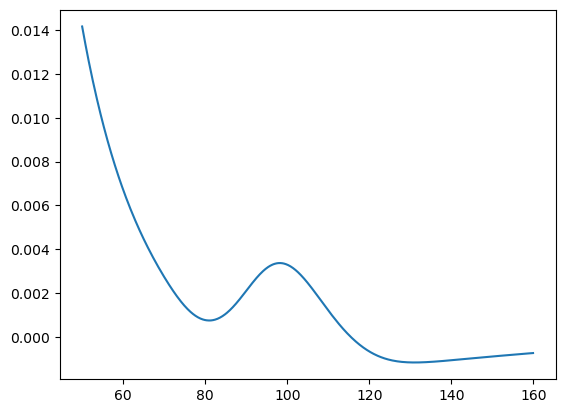

In [3]:
plt.plot(emu_xi.rgrid, Xil_test)

In [4]:
emu_P = PyEffort.load_emu("/home/marcobonici/Desktop/CosmologicalEmulators/trained_emulators/test_train_velocileptor/trained_velocileptor_l_0_z1.bson")
input_cosmo = np.array([3.037842, 0.9553725, 0.67123, 0.0230248, 0.142591])
Pl_test = PyEffort.compute_Pl(input_cosmo, np.ones(11), emu_P)

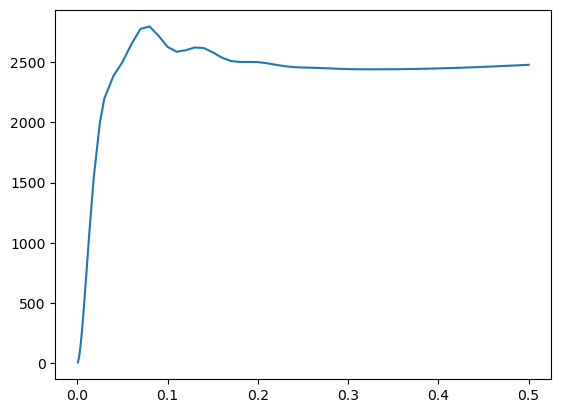

In [5]:
plt.plot(emu_P.kgrid, emu_P.kgrid*Pl_test)

In [6]:
%timeit PyEffort.compute_Xil(input_cosmo, np.ones(6), emu_xi)

106 µs ± 3.48 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%timeit PyEffort.compute_Pl(input_cosmo, np.ones(11), emu_P)

26.1 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
emu_P_pybird_Mono = PyEffort.load_emu("/home/marcobonici/Desktop/CosmologicalEmulators/trained_emulators/trained_effort_emulators/blinded_challenge/PyBird_061_10000_optiresum_final/emulator_PyBird_w0wanucdm_monopole.bson")
emu_P_pybird_Quad = PyEffort.load_emu("/home/marcobonici/Desktop/CosmologicalEmulators/trained_emulators/trained_effort_emulators/blinded_challenge/PyBird_061_10000_optiresum_final/emulator_PyBird_w0wanucdm_quadrupole.bson")

In [9]:
cosmo_jap = np.array([3.11494, 64.8404, 0.31859])
bias_jap = np.array([1.95343, 1.22265, -2.03644, 1.77778, -1.63428, -3.00543, 0])
stoch_jap = np.array([0., -0.696636, -3.69431])
n_bar = 3e-4
f = PyEffort.compute_fz(0.61, cosmo_jap[2], -1., 0.)

In [10]:
Pl_test_PyBird_Mono = PyEffort.compute_Pl(cosmo_jap, bias_jap, f, emu_P_pybird_Mono)
Pl_test_PyBird_Quad = PyEffort.compute_Pl(cosmo_jap, bias_jap, f, emu_P_pybird_Quad)

In [11]:
%timeit PyEffort.compute_Pl(cosmo_jap, bias_jap, f, emu_P_pybird_Mono)

32.8 µs ± 6.13 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
k_bins = PyEffort.create_bin_edges(emu_P_pybird_Mono.P11.kgrid)

In [13]:
%timeit PyEffort.create_bin_edges(emu_P_pybird_Mono.P11.kgrid)

3.23 µs ± 982 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [14]:
stoch_0, stoch_2 = PyEffort.get_stoch_terms_binned_efficient(0., stoch_jap[1], stoch_jap[2], n_bar, k_bins)
%timeit stoch_0, stoch_2 = PyEffort.get_stoch_terms_binned_efficient(0., stoch_jap[0], stoch_jap[1], n_bar, k_bins)

2.72 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


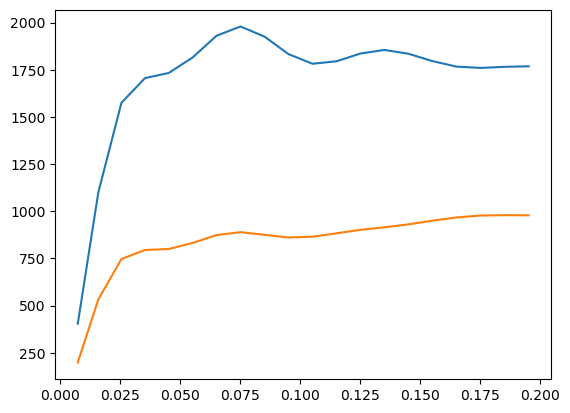

In [15]:
plt.plot(emu_P_pybird_Mono.P11.kgrid, emu_P_pybird_Mono.P11.kgrid*(Pl_test_PyBird_Mono + stoch_0))
plt.plot(emu_P_pybird_Mono.P11.kgrid, emu_P_pybird_Mono.P11.kgrid*(Pl_test_PyBird_Quad + stoch_2))

In [16]:
def theory(theta, n, Mono_Emu, Quad_Emu):
    # θ[0:2] cosmoparams, ln_10_As, H0, ΩM
    # θ[3:8] bias
    # θ[9:10] stoch
    f = PyEffort.compute_fz(0.61, theta[2], -1., 0.)
    my_theta = deepcopy(theta)
    my_theta[7] /= (0.7**2)
    my_theta[8] /= (0.7**2)
    my_theta[4] = (theta[4]+theta[6])/np.sqrt(2)
    my_theta[6] = (theta[4]-theta[6])/np.sqrt(2)
    n_bar = 3e-4
    k_bins = PyEffort.create_bin_edges(Mono_Emu.P11.kgrid)
    stoch_0, stoch_2 = PyEffort.get_stoch_terms_binned_efficient(0., my_theta[9], my_theta[10], n_bar, k_bins)
    Pl_test_PyBird_Mono = PyEffort.compute_Pl(my_theta[0:3], np.hstack((my_theta[3:9], 0.)), f, Mono_Emu) + stoch_0
    Pl_test_PyBird_Quad = PyEffort.compute_Pl(my_theta[0:3], np.hstack((my_theta[3:9], 0.)), f, Quad_Emu) + stoch_2
    return np.hstack((Pl_test_PyBird_Mono[0:n], Pl_test_PyBird_Quad))
    

In [17]:
cosmo_jap_theory = np.array([3.11494, 64.8404, 0.31859])
bias_jap_theory = np.array([1.95343, 1.22265, -2.03644, 1.77778, -1.63428, -3.00543])
stoch_jap_theory = np.array([-0.696636, -3.69431])
theory_jap = np.hstack((cosmo_jap_theory, bias_jap_theory, stoch_jap_theory))

In [18]:
n = 12
first_test = theory(theory_jap, n, emu_P_pybird_Mono, emu_P_pybird_Quad)

In [20]:
%timeit theory(theory_jap, n, emu_P_pybird_Mono, emu_P_pybird_Quad)

142 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


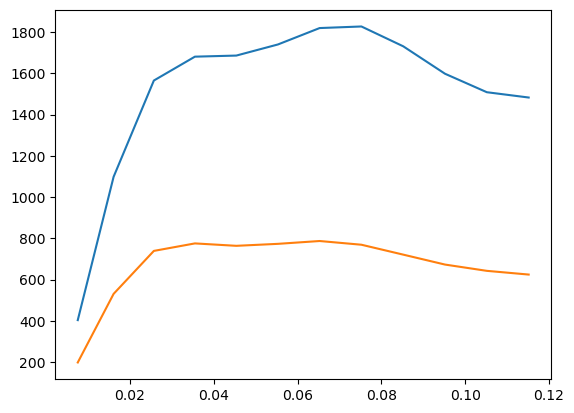

In [19]:
plt.plot(emu_P_pybird_Mono.P11.kgrid[0:n], emu_P_pybird_Mono.P11.kgrid[0:n]*first_test[0:n])
plt.plot(emu_P_pybird_Mono.P11.kgrid[0:n], emu_P_pybird_Mono.P11.kgrid[0:n]*first_test[n:2*n])